# Article
A simple tool to parse + perform NLP on news articles

## Dependencies

In [ ]:
!unzip utils.zip

In [ ]:
!pip install beautifulsoup4
!pip install nltk
!pip install rake-nltk
!pip install bertopic
!pip install wordcloud
!pip install yake
!pip install pytextrank spacy


In [ ]:
!pip install openai

In [ ]:
!pip install google-search-results


In [ ]:
!pip install -U matplotlib

## Imports

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup, NavigableString
import re
import nltk
from rake_nltk import Rake
from bertopic import BERTopic
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk import ngrams
import yake
import spacy
import pytextrank
import en_core_web_sm
from serpapi import GoogleSearch
from urllib.parse import urlparse
import openai
import joblib


In [ ]:
openai.api_key = openai_key

In [ ]:
newsitesdata=pd.read_csv('./utils/data/newsites.tsv', sep='\s+', header=0 )

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
   

In [ ]:
!python -m spacy download en_core_web_sm

## The Article Class

In [ ]:
class Article:
  '''
  Class to analyse news articles.

  
  '''
  def __init__(self, url):
    '''
    Function that initialises the Article object with the url.

    url: full url of the news article to be analysed
    '''
    self.url = url
    self.soup = self.parse(url)
    self.title = self.get_title()
    self.text = self.get_text()
    self.date = self.get_date()
    self.models = ["dt", "nb", "lr", "svm"]

  def __str__(self):
    '''
    Function that generates a formatted string representing the article.
    '''
    return f"Title: {self.title} \n Article:{self.text}"


  def parse(self, url, engine="html.parser"):
    '''
    Function that generates a parser, for parsing the DOM elements that constitute the webpage.

    url: full url of the news article to be analysed
    engine: parser to use to parse the html document. 
      Options:["html.parser","lxml", "html5.lib"] 
      Recommended: "html.parser"

    Returns:
    A beautiful soup parser of the HTML document.
    '''
    # GET the webpage from the URL
    res = requests.get(url)

    # Parse HTML document using beautiful soup.
    soup = BeautifulSoup(res.content, engine)

    # Remove script tags from the HTML
    [s.decompose() for s in soup('script')]


    return soup


  def get_text(self):
    '''
    Function to extract the texts from an article. 
    This includes using various heuristics to find the elements which contain the article body.

    Returns:
    A string which is the textual content of the article.
    '''

    # List to store individual text snippets from DOM nodes.
    texts = []


    #  regex pattern to match with case insensitive strings containing article followed by body
    pattern1 = re.compile(r'article.*body', re.IGNORECASE)

    #  regex pattern to match with case insensitive strings containing article 
    pattern2 = re.compile(r'article*', re.IGNORECASE)

    # Utility function to match attribute value with a given regex pattern, will be used in text extraction heuristic
    def attrs_match(attrs,pattern):
      for key, value in attrs.items():
          if pattern.search(value):
              return True
      return False

    # Utility function to recursively get texts from DOM nodes and their children.
    def get_text_from_element(element, texts=[]):
      try:
        texts.append(element.text)
      except:
        "no text"
      if not isinstance(element, NavigableString):
        for child in element.children:
            texts = get_text_from_element(child, texts)
      return texts

    # node represents list of candidate article nodes

    node = None
    #  Heuristic:
    #  1. Priority 1: article Tag
    #  2. Priority 2: itemProp="articleBody"
    #  3. Priority 3: 3a: class name contains article and body (pattern1)
    #                 3b: class name contains article (pattern2)
    #  4. Priority 4: 4a: has an attribute containing article and body (pattern1)
    #                 4b: has an attribute containing article (pattern2)
    
    if articles := self.soup.find_all('article'):
      node = articles
    elif itemProps := self.soup.find_all(attrs={"itemprop":"articleBody"}) :
      node = itemProps
    elif elements_ab := self.soup.find_all(class_=pattern1):
      node = elements_ab
    elif elements_a := self.soup.find_all(class_=pattern2):
      node = elements_a
    elif elements_ab_alt := self.soup.find_all(attrs= lambda x: attrs_match(x,pattern1)):
      node = elements_ab_alt 
    else:
      elements_a_alt = self.soup.find_all(attrs= lambda x: attrs_match(x,pattern2))
      node = elements_a_alt
      
    # iterate through nodes if node!=None, and extract text recursively
    if node:

      for n in node:
        get_text_from_element(n,texts)
      
    else:
      texts.append("Article could not be scraped.")

    # join texts with a " " in between them

    return (" ").join(texts).strip()
      
      




  def get_title(self):
    '''
    Function to get the title from an article.
    A heuristic inspired by newspaper3k is used here, to find the title of the article

    Returns:
    A string which is the title of the article.
    '''

    # get title tag options
    title_tag = self.soup.find('title')
    h1_tags = self.soup.find_all('h1')
    h1_tags.sort(reverse=True, key= lambda x: len(x.text) if x.text else 0)
    meta_tag = self.soup.find('meta',  property="og:title")

    # get text candidates


    meta_title_text = meta_tag["content"] if meta_tag and meta_tag["content"] else ''
    title_title_text = title_tag.text if title_tag.text else ''
    h1_title_text = h1_tags[0].text if h1_tags and h1_tags[0].text else ''

    # default title set to title tag
    title = title_title_text

    # Heuristic:
    # 1. Priority 1: If title tag's text is equal to the first h1's text, then it is the title
    # 2. Priority 2: If h1's title is equal to meta derived title, then it is the title.
    # 3. Priority 3: If meta derived title is the beginning of the title tag's title, then meta derived title is the title

    if title_title_text==h1_title_text:
      title = title_title_text
    elif h1_title_text == meta_title_text:
      title = h1_title_text
    elif title_title_text.startswith(meta_title_text):
      title = meta_title_text

    # Often, title exists in the form of title | publisher, therefore we split the derived title, and take the longer stringas the title

    title_splits = title.split('|')
    title_splits.sort(key=lambda x: len(x), reverse=True)
    title_final = title_splits[0]

    return title_final


  def get_bias(self):
    '''
    Function to get political bias of the publisher.
    We use data from Media Bias / Fact Check, a think tank which claims, "We are the most comprehensive media bias resource on the internet. 
    There are currently 5700+ media sources and journalists listed in our database and growing every day."

    Returns:
    A string representing media bias. It is one of the following values left | right | center.

    '''

    # normalise the domain in the format that can be matched with the media bias dataset and use it as a key
    domain = urlparse(self.url).netloc
    domain_normalised = '.'.join(domain.split('.')[-2:])
    bias = newsitesdata.loc[newsitesdata['source_url_normalized']== domain_normalised]['bias'].values[0] if newsitesdata.loc[newsitesdata['source_url_normalized']== domain_normalised].empty==False else 0

    return bias


  def get_factuality(self):
    '''
    Function to get factuality/objectivity of the publisher.
    We use data from Media Bias Fact Check, a think tank which claims, "We are the most comprehensive media bias resource on the internet. 
    There are currently 5700+ media sources and journalists listed in our database and growing every day."

    Returns:
    A string representing factuality. It is one of the following values high | mixed | low.
    '''

    # normalise the domain in the format that can be matched with the media bias dataset and use it as a key
    domain = urlparse(self.url).netloc
    domain_normalised = '.'.join(domain.split('.')[-2:])
    fact = newsitesdata.loc[newsitesdata['source_url_normalized']== domain_normalised]['fact'].values[0] if newsitesdata.loc[newsitesdata['source_url_normalized']== domain_normalised].empty==False else 0

    return fact





  def get_date(self):

    '''
    Function to get the publishing date of the article.
    Inspired by newspaper3k, it iterates over a list of possible tags and returns the first matched tag it finds.

    Returns:
    Date string or None depending on if date is found.
    '''


    PUBLISH_DATE_TAGS = [
            {'attribute': 'property', 'value': 'rnews:datePublished',
             'content': 'content'},
            {'attribute': 'property', 'value': 'article:published_time',
             'content': 'content'},
            {'attribute': 'name', 'value': 'OriginalPublicationDate',
             'content': 'content'},
            {'attribute': 'itemprop', 'value': 'datePublished',
             'content': 'datetime'},
            {'attribute': 'property', 'value': 'og:published_time',
             'content': 'content'},
            {'attribute': 'name', 'value': 'article_date_original',
             'content': 'content'},
            {'attribute': 'name', 'value': 'publication_date',
             'content': 'content'},
            {'attribute': 'name', 'value': 'sailthru.date',
             'content': 'content'},
            {'attribute': 'name', 'value': 'PublishDate',
             'content': 'content'},
            {'attribute': 'pubdate', 'value': 'pubdate',
             'content': 'datetime'},
            {'attribute': 'name', 'value': 'publish_date',
             'content': 'content'},
        ]

    for known_meta_tag in PUBLISH_DATE_TAGS:
        meta_tags = self.soup.find_all( attrs={known_meta_tag['attribute']:known_meta_tag['value']})
        if meta_tags:
            date_str = meta_tags[0].get(known_meta_tag['content'])
            if date_str:
              return date_str
    return None
            



  def get_summary(self, frac=0.3):
    '''
    Function to perform extractive summarisation of the article text.

    frac: (0,1]: fraction of sentences of the original article to be considered

    Returns:
    A string representing the summary
    '''

    assert frac>0 and frac<=1, "frac needs to be a float between (0,1]"

    # Tokenise text into sentences
    sentence_list = nltk.sent_tokenize(self.text)

    # Build a corpus of stopwords
    stopwords = nltk.corpus.stopwords.words('english')

    # Find word frequences to find the most common words.
    word_frequencies = {}
    for word in nltk.word_tokenize(self.text):
        if word not in stopwords:
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1

    # Maximum word frequencym to normalise all word frequencies.
    maximum_frequncy = max(word_frequencies.values())

    for word in word_frequencies.keys():
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)

    # Calculating sentence scores:
    # For every sentence, the sentence scores is weighed using the words present in the sentence. 
    # The weight of each word is the normalised frequency discussed above.
    # We only consider sentences with [10,30] words for best results.
    sentence_scores = {}

    for sent in sentence_list:
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                if len(sent.split(' ')) >=10 and len(sent.split(' '))<=30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]


    # Sort sentences by sentence scores
    res = sorted(sentence_scores.items(), key= lambda x:x[1] ,reverse = True)

    # Extract sentences
    res = [r[0] for r in res]

    # Number of sentences to be included in the final summary, given by n
    n = int(frac*len(res))

    #  Final summary by concatenating the sentences.
    summary = " ".join(res[:n])

    return summary


  def get_topics(self):
    '''
    Function that performs two tasks:
    1. Prints a topic hierarchy tree
    2. Returns a list of topics denoted by most frequent key phrases in the topic, as well as frequency of the topic across the document.

    This function uses the BERTopic library. BERTopic finds topic clusters by the follwoing 5 steps:
      1. Find sentence embeddings using a sentence transformer.
      2. Perform dimensionality reduction using UMAP .
      3. Cluster using HDBSCAN.
      4. Tokenise topics
      5. Use tokenised topics to make topic representations.

    '''

    # create documents by tokenising sentences
    docs = nltk.sent_tokenize(self.text)

    # topic modelling

    topic_model = BERTopic()
    topics, probs = topic_model.fit_transform(docs)

    #  hierarchial clustering

    try:
      hierarchical_topics = topic_model.hierarchical_topics(docs)
      tree = topic_model.get_topic_tree(hierarchical_topics)
      print(tree)
    except:
      print("Hierarchial topic model not available, try running the function again")

    return topic_model.get_topic_info()

  def get_keywords(self, algorithm="yake"):
    '''
    A function to find keywords present in the article text.
    We offer two algorithmic options:
    1. YAKE: Yet Another Keyword Extractor 
      Feature extraction in YAKE involves: A) Casing; (B) Word Positional; (C) Word Frequency; (D) Word Relatedness to Context; and (E) Word DifSentence.
    
    2. RAKE:  Rapid Automatic Keyword Extraction 
      The RAKE algorithm extracts keywords using a delimiter-based approach to identify candidate keywords and scores them using word co-occurrences that appear in the candidate keywords.

      YAKE has superior performance over RAKE, and is therefore sued as the default.

    Returns:
    A list of ranked tuples, where each tuple is of the form (kewyord sequence, score). Note that scores between algorithms or documents are not comparable.
    '''

    assert algorithm=="yake" or algorithm=="rake", "Choose a valid algorithm"

    if algorithm=="yake":
      kw_extractor = yake.KeywordExtractor()
      keywords_with_scores = kw_extractor.extract_keywords(self.text)


    elif algorithm=="rake":
      r = Rake()
      r.extract_keywords_from_text(self.text)
      ranked_keywords = r.get_ranked_phrases_with_scores()
      keywords_with_scores = [(kw[1],kw[0]) for kw in ranked_keywords]
  

    return keywords_with_scores 

  def get_word_cloud(self):
    '''
    Function to display a word cloud.

    A word cloud is a visual representation of different words occurring in the corpus. The size of the words is proportional to their frequencies. 
    Stopwords are omitted. Colour scheme is not representative of anything.
    '''

    #  more customisations
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(self.text)
    plt.imshow(word_cloud, interpolation='bilinear')



  def predict_fake_news(self, model):
    '''
    Function to predict if the title indicates that the given news is fake news,

    Returns:
      1: title doesn't indicate fake news
      0: title indiciates fake news
    '''

    assert model in self.models, "Enter valid model: dt,lr,nb or svm"
    model_paths = {
        "dt": "./utils/models/fakenews/decision_tree.pkl",
        "lr": "./utils/models/fakenews/logistic_regression.pkl",
        "nb": "./utils/models/fakenews/naive_bayes.pkl",
        "svm":"./utils/models/fakenews/support_vector.pkl"
    }
    classifier = joblib.load(model_paths[model])

    return classifier.predict([self.title])[0]

  def predict_clickbait(self, model):
    '''
    Function to predict if the title indicates that the given news is clickbait,

    Returns:
      0: title doesn't indicate clickbait
      1: title indiciates clickbait
    '''
    assert model in self.models, "Enter valid model: dt,lr,nb or svm"
    model_paths = {
        "dt": "./utils/models/clickbait/decision_tree.pkl",
        "lr": "./utils/models/clickbait/logistic_regression.pkl",
        "nb": "./utils/models/clickbait/naive_bayes.pkl",
        "svm":"./utils/models/clickbait/support_vector.pkl"
    }
    classifier = joblib.load(model_paths[model])

    return classifier.predict([self.title])[0]



  def get_similar_articles(self):
    '''
    Function to get similar articles, related to the given article.

    Returns:
    A list of articles, each article is formatted as a dictionary with the following keys:
      url: url of the article
      title: title of the article
      snippet: a short snippet which serves as a preview
      snippet_highlighted_words: matched keywords from the search term

    '''

    # Find keywords using YAKE

    keywords =  self.get_keywords(algorithm="yake")

    #  We form the search phrase by picking unique words from the first 5 ranked keywords

    search_terms = []

    for keyword in keywords[:5]:
      keyword_split =  keyword[0].split(" ") 

      for k in keyword_split:
        if k not in search_terms:
          search_terms.append(k)

    search_phrase = " ".join(search_terms)

    # Using SERP API, a real-time API to access Google search results. 

    params_api = {
      "api_key": serp_key,
      "engine": "google",
      "q": search_phrase,
      "location": "Austin, Texas, United States",
      "google_domain": "google.com",
      "gl": "us",
      "hl": "en"
    }

    search_api = GoogleSearch(params_api)
    results_api = search_api.get_dict()

    # Cleaning API results, related_articles is the list of related articles

    related_articles = []

    for article in results_api["organic_results"]:
      new_article = {}

      new_article['url'] = article['link']
      new_article['title'] = article['title']
      new_article['snippet'] =  article['snippet'] if article['snippet']  else ""
      new_article['snippet_highlighted_words'] = article['snippet_highlighted_words']

      related_articles.append(new_article)
    
    return related_articles

  def get_ngrams(self, n=3):
    '''
    Function to get ngrams from the article text.

    Returns a list of ngrams, where each list element is a nested tuple of the format: ((n-gram), frequency).
    '''
    # tokenise text into words, filter words by removing stop words.

    words = nltk.word_tokenize(self.text.lower())
    stop_words = nltk.corpus.stopwords.words('english')

    filtered_words = [w for w in words if not w in stop_words]

    #  use the ngrams function by nltk to find n-grams

    n_grams = ngrams(filtered_words, n)

    # We find frequency of n-grams

    n_grams_freq = {}

    for g in n_grams:
      if g in n_grams_freq.keys():
        n_grams_freq[g] = n_grams_freq[g]+1
      else:
        n_grams_freq[g] = 1

    # Sort n-grams in decreasing order of frequency

    sorted_n_grams = sorted(n_grams_freq.items(), key= lambda x:x[1] ,reverse = True)

    return sorted_n_grams

  def get_ner(self):
    '''
    Function that returns NEs (Named Entities) in the article title.

    Returns:
    A list of tuples, where each tuple is of the format: (Named Entity, Category)
    '''
    ner = en_core_web_sm.load()

    doc = ner(self.title)

    ners = [(X.text, X.label_) for X in doc.ents]

    print(ners)


  def gpt_pointers(self):
    '''
    Function to make points out of the article.

    Returns:
    A list of strings representing the pointers using gpt3.
    '''


    reduced_text = self.text[:2200 if 2200<len(self.text) else len(self.text)]

    prompt = f"Form crisp bullet points from the given article. Ignore irrelevant details such as advertisements and noisy text.\nArticle: {reduced_text} \nPoints:"

    response = openai.Completion.create(
      model="text-davinci-003",
      prompt=prompt,
      temperature=0.7,
      max_tokens=256,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0
    )


    points = response["choices"][0]["text"]

    points_list = points.split("\n")
    return points_list

  def gpt_ask_question(self,question):
    '''
    Function that allows you to ask a question related to the article using GPT3.

    Returns:
    A string which is the answer to the question.
    '''


    reduced_text = self.text[:2200 if 2200<len(self.text) else len(self.text)]

    prompt = f"Answer the given question with reference to the article. If you cannot find an appropriate response, or the question is irrelevant to the article, please indicate in the answer \nArticle: {reduced_text}\nQuestion: {question} \nAnswer:"

    response = openai.Completion.create(
      model="text-davinci-003",
      prompt=prompt,
      temperature=0.7,
      max_tokens=256,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0
    )


    answer = response["choices"][0]["text"]
    return answer.strip()


  def gpt_summary(self):
    '''
    Function which summarises the article using GPT3.

    Returns:
    A string representing the summary.
    '''


    reduced_text = self.text[:2200 if 2200<len(self.text) else len(self.text)]

    prompt = f"Summarise the following article. Ignore irrelevant details such as advertisements and noisy text.\nArticle: {reduced_text} \nSummary:"

    response = openai.Completion.create(
      model="text-davinci-003",
      prompt=prompt,
      temperature=0.7,
      max_tokens=256,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0
    )


    summary = response["choices"][0]["text"]
    return summary.strip()

  

# Module Demo
We try out the Article class on a real news url, and perform the various analysis.


Lets start by initialising an Article object.

In [ ]:
article = Article('https://www.theguardian.com/world/2023/feb/07/earthquakes-in-turkey-and-syria-what-we-know-so-far')

Lets start by printing the article- this will show us the parsed title and article text.

In [ ]:
print(article)

Title: Turkey and Syria earthquake: what we know so far on day two 
 Article:Turkey-Syria earthquake 2023Turkey and Syria earthquake: what we know so far on day twoUN says death toll could rise to more than 20,000 from one of the most powerful earthquakes to hit the region in at least a century

Turkey and Syria earthquake live updates: follow the latest news
 Emergency personnel during a search and rescue operation at the site of a building that collapsed  in Iskenderun, Hatay, in the Turkey-Syria earthquake. Photograph: Erdem Şahin/EPAEmergency personnel during a search and rescue operation at the site of a building that collapsed  in Iskenderun, Hatay, in the Turkey-Syria earthquake. Photograph: Erdem Şahin/EPAHelen Sullivan and Martin BelamTue 7 Feb 2023 00.47 GMTLast modified on Tue 7 Feb 2023 14.27 GMT
Aftershocks, freezing temperatures and damaged roads are hampering efforts to reach and rescue those affected by Monday’s earthquake in southern Turkey and northern Syria, which ha

## Lets perform some basic analysis using classic ML techniques for NLP.

### N-Grams

In [ ]:
article.get_ngrams()

[(('personnel', 'search', 'rescue'), 24),
 (('search', 'rescue', 'operation'), 24),
 (('rescue', 'operation', 'site'), 24),
 (('operation', 'site', 'building'), 24),
 (('site', 'building', 'collapsed'), 24),
 (('building', 'collapsed', 'iskenderun'), 24),
 (('collapsed', 'iskenderun', ','), 24),
 (('iskenderun', ',', 'hatay'), 24),
 ((',', 'hatay', ','), 24),
 (('hatay', ',', 'turkey-syria'), 24),
 ((',', 'turkey-syria', 'earthquake'), 24),
 (('turkey-syria', 'earthquake', '.'), 24),
 (('earthquake', '.', 'photograph'), 22),
 (('.', 'photograph', ':'), 22),
 (('photograph', ':', 'erdem'), 22),
 (('7', 'feb', '2023'), 22),
 (('northern', 'syria', ','), 21),
 (('disaster', 'management', 'agency'), 21),
 (('emergency', 'personnel', 'search'), 17),
 (('tue', '7', 'feb'), 13),
 (('turkey', 'syria', 'earthquake'), 12),
 (('feb', '2023', '00.47'), 12),
 (('.', 'turkey', '’'), 12),
 ((':', 'erdem', 'şahin/epa'), 12),
 (('erdem', 'şahin/epa', 'emergency'), 12),
 (('şahin/epa', 'emergency', 'per

### NERs

In [ ]:
article.get_ner()

[('Turkey', 'GPE'), ('Syria', 'GPE'), ('day two', 'DATE')]


### Extractive Summarisation

In [ ]:
article.get_summary()

'Adelheid Marschang, a WHO senior emergency officer, has said about 23 million people, including 1.4 million children, are likely to be affected by the quake. On Tuesday morning, Turkey’s vice-president, Fuat Oktay, said 3,419 people had been killed in the quake, with another 20,534 injured. The students, members of a volleyball team, were in the city to compete in a sports event when their eight-floor hotel collapsed. Turkey’s disaster management agency said it had 11,342 reports of collapsed buildings, of which 5,775 had been confirmed. The number was expected to rise with the arrival of additional people, the disaster management agency official Orhan Tatar said. The four individuals were held after officers found accounts that shared “provocative posts aiming to create fear and panic”, the police said. Photograph: Erdem Şahin/EPAEmergency personnel during a search and rescue operation at the site of a building that collapsed  in Iskenderun, Hatay, in the Turkey-Syria earthquake.'

### Keywords:
Using YAKE

In [ ]:
article.get_keywords("yake")

[('Turkey Syria Syria', 0.0007545710012582912),
 ('Turkey Turkey Syria', 0.0008799549406467142),
 ('Syria', 0.0009543548862587613),
 ('Turkey', 0.0009992165376132955),
 ('Erdem Şahin', 0.0017732125672323214),
 ('Syria earthquake', 0.0019961403509414894),
 ('northern Syria', 0.0024420498498727),
 ('Oktay Syria Turkey', 0.002841452324467412),
 ('World Health Organization', 0.003322552107439954),
 ('Syria Syria Reuse', 0.004281028373908312),
 ('earthquake', 0.004339328275649864),
 ('Syria earthquake live', 0.004506042110954218),
 ('EPA Emergency personnel', 0.004570177734666898),
 ('GMT Helen Sullivan', 0.004843969885269073),
 ('Monday', 0.005320147928889415),
 ('Tuesday', 0.005612536452239385),
 ('Sullivan and Martin', 0.005864890408447651),
 ('Turkey-Syria earthquake', 0.006004786027866136),
 ('EPA Emergency', 0.006681774384838831),
 ('people', 0.006798131160498249)]

Using RAKE

In [ ]:
article.get_keywords("rake")

[('television images showed thick black smoke rising', 49.0),
 ('television images showed thick black smoke rising', 49.0),
 ('television images showed thick black smoke rising', 49.0),
 ('television images showed thick black smoke rising', 49.0),
 ('television images showed thick black smoke rising', 49.0),
 ('television images showed thick black smoke rising', 49.0),
 ('television images showed thick black smoke rising', 49.0),
 ('television images showed thick black smoke rising', 49.0),
 ('television images showed thick black smoke rising', 49.0),
 ('television images showed thick black smoke rising', 49.0),
 ('disaster management agency official orhan tatar said', 38.81048335248271),
 ('disaster management agency official orhan tatar said', 38.81048335248271),
 ('disaster management agency official orhan tatar said', 38.81048335248271),
 ('disaster management agency official orhan tatar said', 38.81048335248271),
 ('disaster management agency official orhan tatar said', 38.8104833

### Word cloud

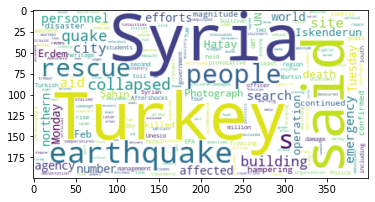

In [ ]:
article.get_word_cloud()

## Classification Algorithms

### Models:
Naive Bayes, Logistic Regression, Linear SVM, Decision tree

### Domains:
Clickbait detection, Fakenews

In [ ]:
article.predict_fake_news("svm")

1

In [ ]:
article.predict_clickbait("nb")

0

## Lets explore topic modelling using BERT

### Topic Modelling

In [ ]:
topic_model = article.get_topics()

100%|██████████| 10/10 [00:00<00:00, 132.09it/s]

.
├─and_earthquake_rescue_in_turkeysyria
│    ├─■──and_feb_2023_efforts_by ── Topic: 3
│    └─earthquake_turkeysyria_personnel_search_in
│         ├─earthquake_to_toll_death_turkey
│         │    ├─■──earthquake_toll_death_syria_to ── Topic: 9
│         │    └─■──deployed_24400_area_more_than ── Topic: 10
│         └─■──building_during_iskenderun_hatay_operation ── Topic: 7
└─the_of_said_in_to
     ├─the_of_said_in_as
     │    ├─the_in_city_as_of
     │    │    ├─■──from_the_thick_black_burning ── Topic: 8
     │    │    └─in_city_the_as_of
     │    │         ├─■──sites_heritage_damage_unesco_world ── Topic: 6
     │    │         └─■──in_hotel_being_students_city ── Topic: 0
     │    └─had_said_disaster_management_people
     │         ├─■──people_million_said_with_quake ── Topic: 2
     │         └─■──had_11342_5775_reports_of ── Topic: 4
     └─aid_the_control_four_police
          ├─■──aid_is_syrian_government_control ── Topic: 1
          └─■──police_posts_provocative_four_accou

In [ ]:
topic_model

,Topic,Count,Name
0,0,30,0_in_hotel_being_students
1,1,30,1_aid_is_syrian_government
2,2,30,2_people_million_said_with
3,3,21,3_and_feb_2023_efforts
4,4,21,4_had_11342_5775_reports
5,5,20,5_police_posts_provocative_four
6,6,20,6_sites_heritage_damage_unesco
7,7,20,7_building_during_iskenderun_hatay
8,8,20,8_from_the_thick_black
9,9,14,9_earthquake_toll_death_syria


## Lets mine additional data using the web

### Similar articles

In [ ]:
article.get_similar_articles()

https://serpapi.com/search


[{'url': 'https://www.wsj.com/story/turkey-and-syria-earthquakes-race-is-on-to-rescue-people-from-the-rubble-7fdc009d',
  'title': 'Turkey and Syria Earthquakes in Photos: Race Is on to ...',
  'snippet': 'Turkey and Syria Earthquakes in Photos: Race Is on to Rescue People From the Rubble. Thousands of people are confirmed dead so far as a ...',
  'snippet_highlighted_words': ['Turkey', 'Syria']},
 {'url': 'http://www.erdemsahin.net/?page_id=403',
  'title': 'Syrian Conflict and Refugee Crisis - Erdem Şahin',
  'snippet': 'Turkish-backed Syrian fighters wave as they are on the way to Northern Syria for. An explosion after an apparent US-led coalition airstrike on Kobane, Syria, as.',
  'snippet_highlighted_words': ['Turkish', 'Syrian', 'Syria', 'Syria']},
 {'url': 'https://epaimages.com/search.pp?pictureid=11286863',
  'title': 'Search for survivors continues after major earthquake hits ...',
  'snippet': '7.2.2023 by ERDEM SAHIN ... more injured after a major 7.8 magnitude earthquake 

## State of the Art NLP: Prompting GPT3

### Summarise using GPT3

In [ ]:
article.gpt_summary()

'On Tuesday morning, the death toll from the 7.8-magnitude earthquake that struck southern Turkey and northern Syria rose to 5,021. Over 20,000 people have been injured and an estimated 23 million people are affected by the quake. The World Health Organization warned the number of fatalities could exceed 20,000. Turkey has deployed over 24,400 search and rescue personnel and 3,400 people have taken shelter in trains used as emergency accommodation. Syria has been accused of playing politics with aid.'

### Generate Pointers

In [ ]:
points = article.gpt_pointers()

In [ ]:
print(*points, sep="\n")


- 7.8-magnitude earthquake hit southern Turkey and northern Syria on Monday
- Death toll estimated to exceed 20,000
- Nearly 23 million people, including 1.4 million children, affected by the quake
- Turkey: 3,419 killed, 20,534 injured and 11,342 reports of collapsed buildings
- Syria: 1,602 killed
- Turkey deployed 24,400 search and rescue personnel to the quake area
- Syria accused of playing politics with aid


### Ask Questions

In [ ]:
article.gpt_ask_question("Who is Fuat Oktay? What did he say?")

"Fuat Oktay is Turkey's vice-president. He said that 3,419 people had been killed in the quake, with another 20,534 injured."

In [ ]:
article.gpt_ask_question("Who are the most affected by the earthquake?")

'The World Health Organization estimates that around 23 million people, including 1.4 million children, are likely to be affected by the earthquake.'

In [ ]:
article.gpt_ask_question("Who is the fisheries minister of India ?")

'Irrelevant to the article.'